In [909]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split as scikit_train_test_split
from surprise import Reader, Dataset, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, CoClustering, SlopeOne, SVDpp, NMF, BaselineOnly
from surprise.model_selection import KFold, RepeatedKFold, cross_validate, GridSearchCV, LeaveOneOut
from surprise.model_selection import train_test_split as surprise_train_test_split
import time

Data import:

In [910]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")

Data cleaning - Drop all categories which do not contain hard skills:

In [911]:
obsolete_categories = [
                "Betriebssystem",
                "Dienste",
                "Produkterfahrung",
                "Methoden und Praktiken",
                "Projektmanagement / Vorgehensmodelle",
                "Sprachen",
                "Einsatzfelder / Erfahrungen / Schwerpunkte",
                "Issue Management",
                "Branchenerfahrung",
                "Zertifizierung",
                "Beratung",
                "Agilität",
                "Tests",
                "Rolle (intern)",
                "nxp Abteilungen"
                ]

In [912]:
# df = df[~df["category"].isin(obsolete_categories)]

alle skills, die seltener als x mal vorkommen (zB x = 10) rausschmeiß0en


Declare various aiding variables

In [913]:
persons = df["person"].unique()
skills = sorted(df["skill"].unique())
categories = df["category"].unique()

In [914]:
employee_dict = {}
for n in range(1,len(persons)+1):
    employee_dict[n] = persons[n-1]

In [915]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Since this notebook demonstrates the a recommender system which deals with rated skills and the underlying data does not offer ratings, this measure will be implemented in the following way: 
- For each skill, the frequency of the underlying category will be measured. The skills will be rated according to this frequency 
- For example: If an employee has most skills in the category "Programmiersprachen", these skills will receive the highest rating

In [916]:
def scaler_1_5(x,old_max,old_min):
    old_range = (old_max - old_min)  
    if (old_range == 0):
        return 1
    else:
        new_range = (5 - 1) 
        x_std = (x - old_min)/(old_max-old_min)
        return round(x_std * new_range + 1)

In [917]:
# create dataframe for each employee and their category count
category_per_employee = pd.DataFrame(index=categories)
for p in persons:
    p_skills = df[df["person"] == p]
    # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    skill_values = np.array([])
    # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in categories:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
    category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

In [918]:
df_rated = pd.DataFrame()
for p in persons:
    # get employee
    df_subset = df[df["person"] == p].copy()
    # get skills of employee
    p_skills = df_subset["skill"].to_numpy()
    # initialize empty array for ratings
    ratings = np.zeros(len(p_skills))
    # fill array for each skill with respective category value 
    for i in range(0,len(p_skills)): 
        ratings[i] = category_per_employee.loc[category_dict[p_skills[i]]][p]
    # append ratings to subset and drop category column
    df_subset["rating"] = ratings
    df_subset.drop("category",axis=1,inplace=True)
    # append user to df
    df_rated = pd.concat([df_rated,df_subset],ignore_index=True)

## Comparing Different Recommender Systems

Define holdout data: We want to take out 2 skills with high rating of 40% of users. Skills and users should be chosen randomly. 

In [871]:
# df_rated[df_rated["person"] == 624]

In [921]:
# specify how many datapoints should be stored in holdout (e. g. holdout_size = 0.1 -> 10% of datapoints will be put in holdout)
holdout_size = 0.1
# save original size of data for termination of while loop 
size_data = len(df_rated)
holdout = pd.DataFrame()
# get list which represents each employee with their number of entered skills in the data
employee_occurence = df_rated["person"].to_list()
# initialize random seed
seed = 0 
while len(holdout)/size_data < holdout_size:
    # randomly select employee (affected by how often they occur in the data)
    np.random.seed(seed)
    df_subset_emp = df_rated[(df_rated["person"] == np.random.choice(employee_occurence))]
    # if condition causes that employee do not get completely deleted from dataset
    if len(df_subset_emp) > 1:
        max_rating_emp = df_subset_emp["rating"].max()
        holdout_emp = df_subset_emp[df_subset_emp["rating"] == max_rating_emp].sample(n=1,random_state=seed)
        df_rated = df_rated.drop(holdout_emp.index)
        holdout = pd.concat([holdout,holdout_emp],ignore_index=True)
    # change seed for next while iteration
    seed = seed + 1

In [809]:
# perc_users = 0.4
# n_skills = 2
# sample_size = int(np.ceil(len(persons)*perc_users))

# random.seed(1)
# sample = random.sample(population=persons.tolist(),k=sample_size)

# min_rating = 5

In [810]:
# holdout = pd.DataFrame()

# user_sample = []
# for person in sample: 
#     df_subset = df_rated[(df_rated["person"] == person) & (df_rated["rating"] >= min_rating)]
#     # try to get two random high ranking skills (if the employee doesn't have high ranking skills they will be skipped)
#     try:
#         holdout_employee = df_subset.sample(n=n_skills,random_state=1)
#         user_sample.append(person)
#         df_rated = df_rated.drop(holdout_employee.index)
#         holdout = pd.concat([holdout,holdout_employee],ignore_index=1)
#     except ValueError:
#         pass 
# holdout

In [885]:
reader = Reader(rating_scale=(1,5)) 
data = Dataset.load_from_df(df_rated,reader)

In [812]:
NUM_TRIALS = 3
NUM_SPLITS = 5

In [982]:
def gridsearch_cv(algo_class,algo_name,param_grid,data,best_model_dict,best_params_dict):
    start = time.time()
    rmse = np.zeros(NUM_TRIALS)
    mse = np.zeros(NUM_TRIALS)
    mae = np.zeros(NUM_TRIALS)
    models = []
    params = []

    # hier eventuell gridsearch rein? 
    for i in range(NUM_TRIALS):
        print("Running CV for model", algo_name ,"in Iteration:", i ,"at", time.time()-start)
        cv = KFold(
                        n_splits=NUM_SPLITS,
                        random_state=i
                        # min_n_ratings=i
                    )
                        # COMMENT: min_n_ratings -> what's the impact of this parameter? 
        gs = GridSearchCV(
                        algo_class,
                        param_grid, 
                        measures=["rmse","mse","mae"], 
                        cv=cv,refit="rmse"
                    )
        gs.fit(data)
        rmse[i] = gs.best_score["rmse"]
        mse[i] = gs.best_score["mse"]
        mae[i] = gs.best_score["mae"]
        models.append(gs.best_estimator["rmse"])
        params.append(gs.best_params["rmse"])

    # hier noch erläutern, warum rmse als ausschlaggebene measure gewählt wird
    best_model_dict[algo_name] = models[np.argmin(rmse)]
    best_params_dict[algo_name] = params[np.argmin(rmse)]

    print("Total time: ", (time.time()-start), "sec.")
    return rmse, mse, mae 

In [814]:
def add_result(results, name, rmse, mse, mae):
    '''
    Function adding the results returned by nested_cv to a dataframe. 
    Results will be aggregated for better comparison. 
    Parameters: 

    Output:
    results DataFrame containing an additional row
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":rmse.mean(), 
        "rmse_std":rmse.std(), 
        "mse_mean":mse.mean(), 
        "mse_std":mse.std(), 
        "mae_mean":mae.mean(), 
        "mae_std":mae.std()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [815]:
results = pd.DataFrame()
best_model_dict = {}
best_params_dict = {}

In [816]:
algo_list = [
                (BaselineOnly,"Baseline",{
                                                "verbose":[False]
                                    }),
                (KNNBasic,"k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (KNNWithMeans,"Centered k-NN",{
                                                "k": [20, 40, 60, 80],
                                                "min_k": [1, 5, 10, 20],
                                                "verbose":[False]
                                    }),
                (SVD,"SVD",{
                                                "n_factors": [40, 60, 80, 100, 120],
                                                "n_epochs": [100, 200, 500, 1000, 2000, 5000],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    }),
                (SVDpp,"SVD++",{
                                                "n_factors": [40, 60, 80, 100, 120],
                                                "n_epochs": [100, 200, 500, 1000, 2000, 5000],
                                                "random_state":[1]
                                    }),
                (CoClustering,"CoClustering",{
                                                "n_cltr_u": [2, 3, 4],
                                                "n_cltr_i": [2, 3, 4],
                                                "n_epochs":[10, 20, 40, 60]
                                    }),
                (SlopeOne,"SlopeOne",{
                                    }),
                (NMF,"NMF",{
                                                "n_factors": [10, 15, 20, 40],
                                                "n_epochs": [20, 40, 80, 120],
                                                "biased":[True,False],
                                                "random_state":[1]
                                    })
            ]

In [817]:
for algo in algo_list:
    rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict,best_params_dict)
    results = add_result(results,algo[1],rmse, mse, mae)

In [818]:
best_params_dict

In [819]:
results

Select best performing model and fit it on full data:

In [820]:
#model = NMF(n_factors= 40, n_epochs = 120, biased = False, random_state= 1)
#model = SVDpp(n_factors = 40, n_epochs= 60, random_state=1)
model = best_model_dict[results.iloc[results["rmse_mean"].idxmin()]["name"]]
trainset = data.build_full_trainset()
model.fit(trainset)

In [983]:
# results_2 = pd.DataFrame()
# best_model_dict_2 = {}
# best_params_dict_2 = {}

In [984]:
# algo_list_2 = [
#                    (SVD,"SVD",{
#                                                 "n_factors": [60, 80, 100, 120],
#                                                 "n_epochs": [100, 200, 500, 1000, 2000, 5000],
#                                                 "biased":[True,False],
#                                                 "random_state":[1]
#                                     })]

In [985]:
# for algo in algo_list_2:
#     rmse, mse, mae = gridsearch_cv(algo[0],algo[1],algo[2],data,best_model_dict_2,best_params_dict_2)
#     results_2 = add_result(results_2,algo[1],rmse, mse, mae)

Running CV for model SVD in Iteration: 0 at 0.0
Running CV for model SVD in Iteration: 1 at 333.33647179603577
Running CV for model SVD in Iteration: 2 at 664.9931435585022
Total time:  994.6395263671875 sec.


In [986]:
best_params_dict_2

{'SVD': {'n_factors': 60,
  'n_epochs': 1000,
  'biased': False,
  'random_state': 1}}

In [987]:
results_2

,name,rmse_mean,rmse_std,mse_mean,mse_std,mae_mean,mae_std
0,SVD,0.499353,0.002382,0.249548,0.00244,0.29512,0.001504


In [989]:
model = best_model_dict_2["SVD"]
trainset = data.build_full_trainset()
model.fit(trainset)

Predict ratings for all skills which the employees do not yet have (meaning which do not have an existing rating):

In [990]:
preds = model.test(trainset.build_anti_testset())

## Evaluation

Idea for evaluating the recoms: define holdout a bit differently. Pick random users (say 30% of all users) and remove a prior defined amount of skills (say 2) from their skillset. The skills should have a high rating (say 4 or 5). If these skills then show up as recommendations, we have an objective indicator that the recommendations are somewhat meaningful. 

Evaluation using holdout data: 

In [991]:
from collections import defaultdict

def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = {}
    
    for uid, iid, true_r, est, _ in predictions:
        try:
                top_n[uid].append((iid, est))
        except KeyError:
                top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Get recommendations for all users:

In [992]:
def get_recommendations(preds,n):
    top_n = get_top_n(preds, n)
    recommendations = pd.DataFrame()

    for uid, user_ratings in top_n.items():
        recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
        recommendations = pd.concat([recommendations,recom])

    return recommendations

In [993]:
get_recommendations(preds,10)

,0,1,2,3,4,5,6,7,8,9
12,AIX,Windows Communication Foundation (WCF),Dependency Injection,Objektrelationale Abbildung (ORM),Test Driven Development (TDD),BizTalk,Java FX,Behaviour Driven Development (BDD),Xerces,Phyton /Jython
13,NHibernate,Kendo UI,DevExpress,Microsoft Enterprise Library,BizTalk,NUnit,ASP.NET,ADO.NET,Windows Communication Foundation (WCF),Silverlight
15,Vue.js,Storybook,Cypress,ITCSS,Jest,SCSS,Magento,PHP,HTML5,HTML
16,CSS,Cypress,Ajax,HTML5,Magento,jQuery,Node.js,ITCSS,Storybook,xHTML
17,SAP Commerce 6.x,RFC,Newsletter Anbindung,Tailwind CSS,Solr,Backoffice Konfiguration,SAP ERP Anbindung,Security,WCMS,B2B Accelerator Experience
...,...,...,...,...,...,...,...,...,...,...
1467,TypoScript,Ruby,C/C++,Python,Delphi,Assembler,Pascal,VB/VBA,Groovy,PL/SQL
1474,Magento,Web Components,Dojo Toolkit,Zend,GitHub,"Layouting (Flexbox, CSS Grid)",Yii,Stylelint,Agile Methoden,SCSS
1475,Java EE,JUnit,Hibernate,JDBC,Log4J,Spring,Spring Boot,ASP.NET MVC-Framework,TopLink,Jakarta Commons
1479,.NET Framework,LINQ,NHibernate,Windows Forms,DevExpress,ASP.NET,ASP.NET MVC-Framework,NUnit,.NET Compact Framework,Entity Framework


In [994]:
def get_recoms_for_employee(emp_id,n):
    return get_top_n(preds, n)[emp_id]

In [995]:
get_recoms_for_employee(233,10)

[('TopLink', 4.487679418519185),
 ('StyleReport', 4.40619411760615),
 ('Xerces', 4.328752242921443),
 ('Castor', 4.294771125297062),
 ('Phyton /Jython', 4.227044061570951),
 ('Struts (bis Version 1.3)', 4.22541280321762),
 ('Eclipse', 4.197212510683182),
 ('Java ME', 4.193887017849553),
 ('Cocoon', 4.06173597976665),
 ('Kendo UI', 3.9887359207737756)]

In [996]:
# def get_recoms_for_employee_2(emp_id,n):
#     df_subset = df_rated[df_rated["person"] == 233]
#     recom_df = pd.DataFrame()
#     recom_df["skill"] = skills
#     recom_df["person"] = emp_id
#     employee_ratings = np.zeros(len(skills))
#     for i in range(0,len(skills)): 
#         try:
#             employee_ratings[i] = df_subset[df_subset["skill"] == skills[i]]["rating"]
#         except ValueError:
#             employee_ratings[i] = np.nan
#     recom_df["rating"] = employee_ratings
#     recom_df = recom_df[["person","skill","rating"]]
#     #return recom_df.to_numpy()
#     preds = model.test(recom_df.to_numpy())
#     return get_top_n(preds,n)

Measure precisions: 

In [997]:
def precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())
    
    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0

        for recom in recoms_emp:
            if recom in holdout_emp:
                score = score + 1

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [998]:
def weighted_precision_at_k(k,holdout,recommendations):
    precision = np.zeros(holdout["person"].nunique())

    for i,emp in enumerate(holdout["person"].unique()):
        holdout_emp = holdout[holdout["person"] == emp]["skill"].to_list()
        recoms_emp = recommendations.loc[emp].to_list()

        if len(recoms_emp)>k:
            recoms_emp = recoms_emp[:k]

        score = 0
        num_hits = 0

        for j,recom in enumerate(recoms_emp):
            if recom in holdout_emp:
                num_hits = num_hits + 1
                score = score + (num_hits / (j+1))

        precision[i] = score/min(len(holdout_emp),k)

    return np.mean(precision)

In [999]:
precision_at_k(10,holdout,get_recommendations(preds,10))

0.480391822440533

In [1000]:
weighted_precision_at_k(10,holdout,get_recommendations(preds,10))

0.26094505609736196

Recommendations in respect to top skills and skill categories:

In [979]:
def evaluate_employee_recoms(emp_id,n):
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df[df["person"] == emp_id]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(emp_id))
    top_n_skills = df_rated[df_rated["person"] == emp_id].sort_values(by="rating",ascending=False).head(n).reset_index()[["skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(get_recommendations(preds,n).loc[emp_id].T)
    recoms_catgories = recoms_for_emp.replace({emp_id:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({emp_id:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax = axes[1],
                            kind = "barh",
                            xticks = np.arange(0,recoms_catgories.max()+1,1),
                            #ylabel="Count",
                            title = "Category Count of Recommended Skills - Employee "+str(emp_id))
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_n_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top " + str(n) + " Actual Skills","Recommendations"]
    return return_table

,Top 12 Actual Skills,Recommendations
0,Microsoft Enterprise Library,Castor
1,Silverlight,TopLink
2,Spring,Xerces
3,Smalltalk,StyleReport
4,Perl,Eclipse
5,Assembler,Phyton /Jython
6,OpenShop,Jogl
7,Swing,Struts (bis Version 1.3)
8,Swing,Java ME
9,JSP,GEF


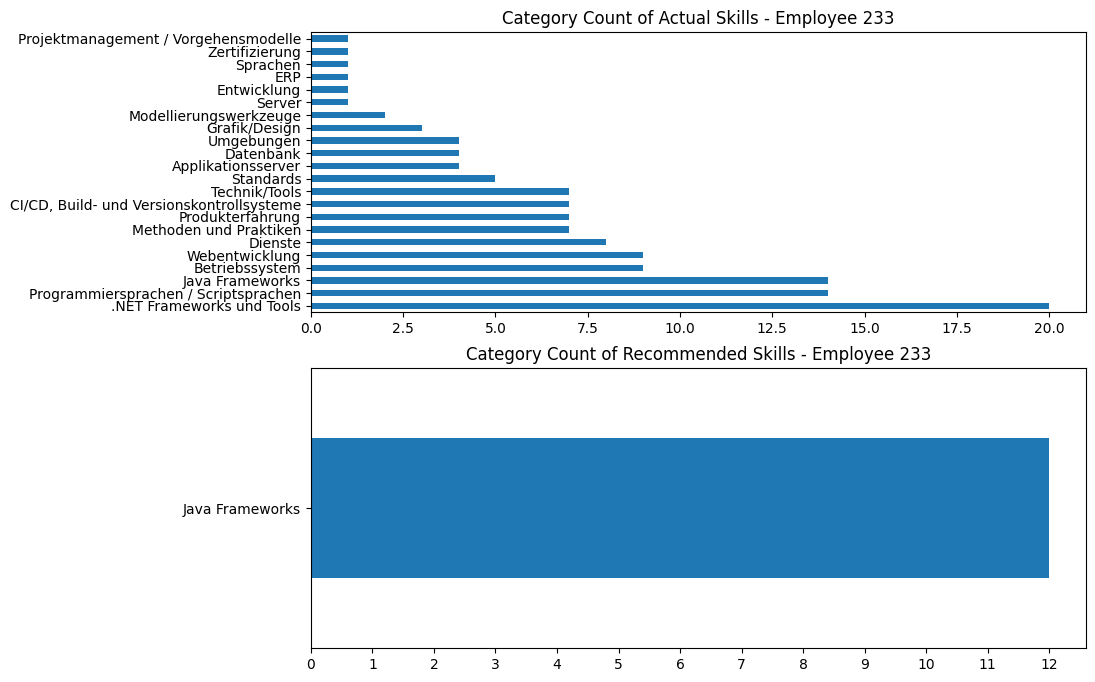

In [981]:
evaluate_employee_recoms(233,12)

Recommendations for new employee:

In [575]:
def get_recoms_for_new_employee(new_id,skilldict,model):

    all_ids = df_rated["person"].unique()
    all_skills = df_rated["skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in skilldict.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_test = []
    for skill in all_skills:
        try:
            skill_rating = skilldict[skill]
            new_test.append((new_id,skill,skill_rating))
        except KeyError:
            new_test.append((new_id,skill,np.nan))
    
    predictions = model.test(new_test)

    return get_top_n(predictions, n=10)[new_id]

In [567]:
new_id = 8774
new_skills = {
                # "Windows 11":4,
                # "Englisch":4,
                # "Chinesisch (Mandarin)":2,
                "Python":4,
                "MATLAB":2,
                "Java":2,
                "MySQL":3,
                "SQLBase":3,
                "Microsoft SQL Server":3,
                "Google Cloud Platform":2,
                "MongoDB":1,
                "JSON":1,
                "Docker":2,
                "Power BI":3,
                "Postman":2,
                "PowerShell":2,
                "Github actions":2
            }

In [576]:
get_recoms_for_new_employee(new_id,new_skills,model)

[('WebDynpro', 4.043575536525699),
 ('TopLink', 4.0362669752127145),
 ('Castor', 4.03482606080636),
 ('Xerces', 4.011753790782273),
 ('Oracle XDK', 4.0050827344594655),
 ('StyleReport', 4.004023553452964),
 ('GEF', 3.985338579031691),
 ('Axure RP', 3.9700097332078617),
 ('Spring-Batch', 3.9650667833275097),
 ('Jakarta Commons', 3.9569549680843283),
 ('Struts (bis Version 1.3)', 3.9356861915340815),
 ('Xamarin', 3.933194825489371),
 ('Security', 3.9295618311037246),
 ('Tailwind CSS ', 3.9183477639052455),
 ('Jogl', 3.8937290017131767),
 ('ITCSS', 3.8923105994683485),
 ('Kendo UI', 3.8905994183194275),
 ('TestNG', 3.8869842664546512),
 ('Layouting (Flexbox, CSS Grid)', 3.8719214913833198),
 ('RFC', 3.8669094855470143),
 ('MSBuild', 3.861118608289978),
 ('Smartedit', 3.8583688551498425),
 ('Spring-JPA', 3.8536902585155577),
 ('Portlet API', 3.8436521934004757),
 ('Yii', 3.843157088655174),
 ('Java FX', 3.8418619603274777),
 ('Django', 3.837728637427281),
 ('Produktkonfigurator', 3.8367519